In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
class lof_point_train:
    def __init__(self,k):
        self.k=k
        self.d_border=None
        self.neighborhood=None
        self.d_reach=None
        self.density=None
        self.distances=None
        self.indices=None
        self.k_distances=None

    def get_nbr_info(self,X):
        nn=NearestNeighbors(n_neighbors=self.k+1,metric='euclidean')
        nn.fit(X)
        self.distances,self.indices=nn.kneighbors(X)
        self.d_border=self.distances[:,-1]
        self.neighborhood=self.indices[:,1:]
        self.k_distances=self.distances[:,1:]
        self.d_reach=np.maximum(self.distances[:,1:],self.k_distances[:,-1][:,np.newaxis])
        self.density=1/np.mean(self.d_reach[:,:self.k],axis=1)

In [3]:
def get_lof(k,X,y,model):
    dist=np.linalg.norm(X-y,axis=1)
    
    indices = np.argsort(dist)[:k]
    k_dist=dist[indices]
    d_border=k_dist[-1]
    d_reach=np.maximum(dist[indices],d_border)
    density=1/(np.sum(d_reach)/k)
    dissimilarity=(model.density[indices])/density
    return np.mean(dissimilarity)

Initialise the lof_point_train

In [4]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
seed = 1337

def get_data(df, clean_train=True):
   
    clean = df[df.Class == 0].copy().reset_index(drop=True)
    fraud = df[df.Class == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)
        
        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)
        
        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]
    
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = get_data(df,clean_train=True)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


In [6]:
seed = 1337

def get_data(df, clean_train=True):
   
    clean = df[df.Class == 0].copy().reset_index(drop=True)
    fraud = df[df.Class == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)
        
        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)
        
        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]
    
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = get_data(df,clean_train=True)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


In [7]:
print(train_X.shape)

(283823, 30)


In [8]:
print(train_y.shape)

(283823, 1)


In [9]:
model=lof_point_train(k=100)
model.get_nbr_info(train_X)


In [10]:
print(model.density.shape)

(283823,)


In [11]:
lof_array=[]
for x in test_X.values:
    lof_array.append(get_lof(k=100,X=train_X.values,y=x,model=model))
    
    

In [12]:
# print(lof_array)

In [13]:
sorted_indices = np.argsort(lof_array)
lof_array=np.array(lof_array)

sorted_values = lof_array[sorted_indices]
sorted_tags = test_y.iloc[sorted_indices]
pd.set_option('display.max_rows', None)
# print(sorted_tags)


In [14]:
#defining threshold=1.022706367005985
threshold=1.022706367005985
y_pred=np.ones(len(lof_array))
for i in range(len(lof_array)):
    if(lof_array[i]>threshold):
        y_pred[i]=1
    else:
        y_pred[i]=0

TP=0
TN=0
FP=0
FN=0

for i in range(y_pred.shape[0]):
    if y_pred[i]==test_y.iloc[i].values and y_pred[i]==1:
        TN=TN+1
    elif y_pred[i]==test_y.iloc[i].values and y_pred[i]==0:
        TP=TP+1
    elif y_pred[i]!=test_y.iloc[i].values and y_pred[i]==0:
        FP=FP+1
    else:
        FN=FN+1


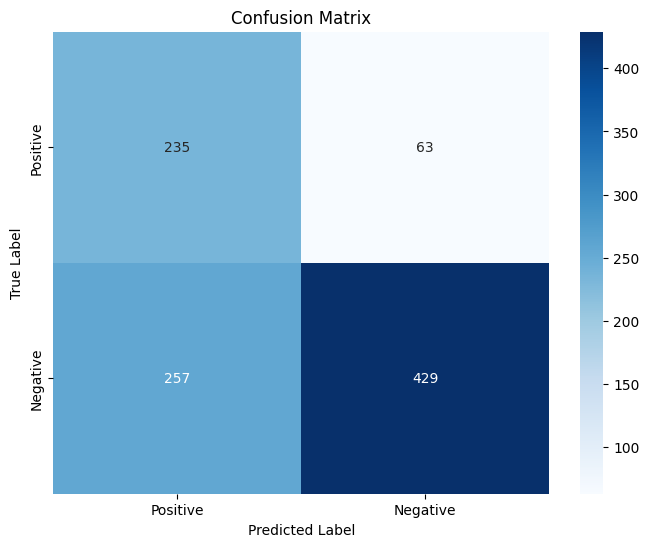

In [15]:
conf_matrix = np.array([[TP, FP],
                        [FN, TN]])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [16]:
print("Precision:", TP/(TP+FP))
print("Recall:", TP/(TP+FN))
print("F1_Score:", (2*TP)/((2*TP)+FP+FN))
print("Accuracy:", (TP+TN)/(TP+TN+FP+FN))

Precision: 0.7885906040268457
Recall: 0.47764227642276424
F1_Score: 0.5949367088607594
Accuracy: 0.6747967479674797
